In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{w_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{w_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{w_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{w_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{w_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{w_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
#prefix = './retrieval_outputs/fiducial_K_B_ret_9/test_'
#w_set = 'K2166'
#n_params = 28
#prefix = './retrieval_outputs/fiducial_K_B_ret_18/test_'
#w_set = 'K2166'
#n_params = 28

prefix = './retrieval_outputs/fiducial_K_B_ret_22/test_'
w_set = 'K2166'
n_params = 28

res = read_results(prefix=prefix, n_params=n_params, w_set=w_set)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, Cov, bestfit_params = res
del res

  analysing data from ./retrieval_outputs/fiducial_K_B_ret_22/test_.txt
(2374, 28)


In [3]:
import copy
from tqdm import tqdm
import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d

def get_pRT_atm(prefix, w_set, bestfit_params, Chem, PT, vsini_local=1):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{w_set}.pkl')

    # Compute global model spectrum
    params_global = bestfit_params['params'].copy()
    pRT_atm.params = params_global

    m_spec_global = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
    m_spec_global.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_global.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    # Compute local model spectrum
    params_local = params_global.copy()
    params_local['vsini'] = vsini_local
    params_local['epsilon_limb'] = 0
    params_local['epsilon_lat'] = 0
    params_local['dif_rot_delta'] = 0
    params_local['dif_rot_phi'] = 1
    pRT_atm.params = params_local

    # Local abundances
    mf_local = Chem.mass_fractions.copy()
    for key_i in mf_local.keys():
        if key_i != 'H2O_pokazatel_main_iso':
            mf_local[key_i] *= 0
        #if key_i != 'CH4_hargreaves_main_iso':
        #    mf_local[key_i] *= 0
        #if key_i != 'CO_main_iso':
        #    mf_local[key_i] *= 0

    #print(mf_local)
    #mf_local['CH4_hargreaves_main_iso'] *= 0
    #mf_local['H2O_pokazatel_main_iso'] *= 0

    m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
    m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec_global, m_spec_local

def get_CCF(
        d_spec, m_spec_local, m_spec_global, LogLike, Cov, rv=np.arange(-1000,1000+1e-6,1)
        ):
    
    CCF = np.nan * np.ones(
        (len(rv), d_spec.n_orders, d_spec.n_dets)
        )
    
    d_wave = d_spec.wave
    d_res = d_spec.flux - LogLike.f[:,:,None]*m_spec_global.flux
    
    # Apply high-pass filter to the residuals
    mask = d_spec.mask_isfinite

    lp_d_res = np.nan*np.ones_like(d_res)
    lp_d_res[mask] = gaussian_filter1d(
        d_res[mask], sigma=300, axis=-1, mode='reflect'
        )
    d_res -= lp_d_res

    for i, rv_i in enumerate(tqdm(rv)):

        for j in range(d_spec.n_orders):
            
            # Shift the model spectrum
            m_wave_local = np.copy(m_spec_local.wave_pRT_grid[j])
            m_wave_local *= (1 + rv_i/(nc.c*1e-5))

            m_flux_local = np.copy(m_spec_local.flux_pRT_grid[j])

            for k in range(d_spec.n_dets):

                # Subtract the global model?
                #m_res_local_jk = LogLike.f[j,k] * (m_flux_local)# - m_spec_global.flux_pRT_grid[j])
                m_res_local_jk = LogLike.f[j,k] * (m_flux_local - m_spec_global.flux_pRT_grid[j])
                
                # Optimal scaling
                #m_res_local *= LogLike.f[j,:][:,None]
                
                # Don't consider the nans
                mask_jk = d_spec.mask_isfinite[j,k]

                # Interpolate onto the data wavelength grid
                m_res_local_jk = np.interp(
                    d_wave[j,k], xp=m_wave_local, fp=m_res_local_jk
                    )
                
                lp_m_res_local_jk = np.nan*np.ones_like(m_res_local_jk)
                lp_m_res_local_jk[mask_jk] = gaussian_filter1d(
                    m_res_local_jk[mask_jk], sigma=300, axis=-1, mode='reflect'
                    )
                m_res_local_jk -= lp_m_res_local_jk

                # Compute the covariance-weighted dot-product
                CCF[i,j,k] = np.dot(
                    m_res_local_jk[mask_jk], 1/LogLike.beta[j,k]**2 * Cov[j,k].solve(d_res[j,k,mask_jk])
                    )

    return CCF, rv

In [4]:
m_spec_global, m_spec_local = get_pRT_atm(prefix, w_set, bestfit_params, Chem, PT, vsini_local=1)

In [5]:
CCF, rv = get_CCF(
    d_spec, m_spec_local, m_spec_global, LogLike, Cov, rv=np.arange(-200,200+1e-6,1)
    )

100%|██████████| 401/401 [00:17<00:00, 23.26it/s]


-3.0


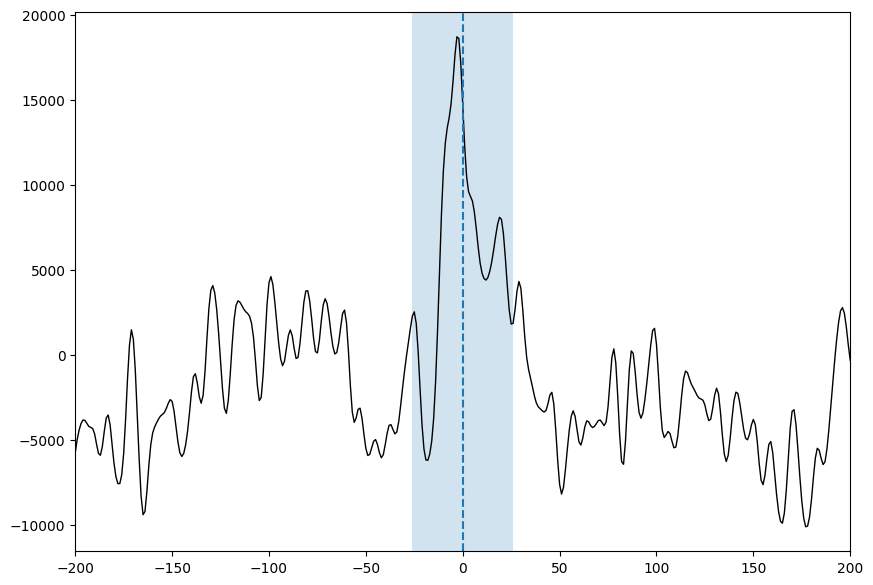

In [6]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(rv, CCF.sum(axis=(1,2)), c='k', lw=1)

#idx = np.argmax(CCF.sum(axis=(1,2)))
#ax.axvline(rv[idx], c='k', ls='-', lw=1)
print(rv[np.argmax(np.nansum(CCF, axis=(1,2)))])

ax.axvline(0, c='C0', ls='--')
ax.axvspan(
    xmin=-bestfit_params['params']['vsini'], 
    xmax=bestfit_params['params']['vsini'], 
    fc='C0', ec='none', alpha=0.2
    )

ax.set(xlim=(-200,200))
plt.show()

-4.0


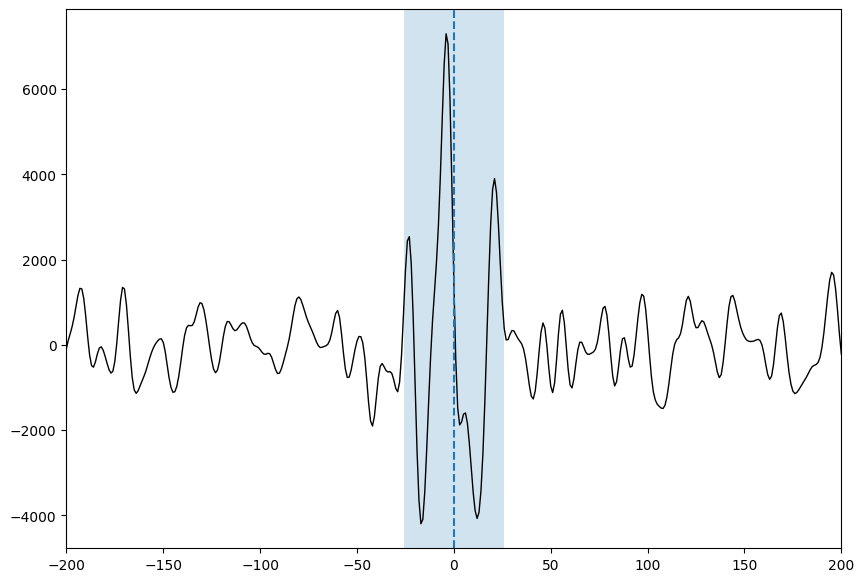

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(rv, CCF.sum(axis=(1,2)), c='k', lw=1)

#idx = np.argmax(CCF.sum(axis=(1,2)))
#ax.axvline(rv[idx], c='k', ls='-', lw=1)
print(rv[np.argmax(np.nansum(CCF, axis=(1,2)))])

ax.axvline(0, c='C0', ls='--')
ax.axvspan(
    xmin=-bestfit_params['params']['vsini'], 
    xmax=bestfit_params['params']['vsini'], 
    fc='C0', ec='none', alpha=0.2
    )

ax.set(xlim=(-200,200))
plt.show()

882.0


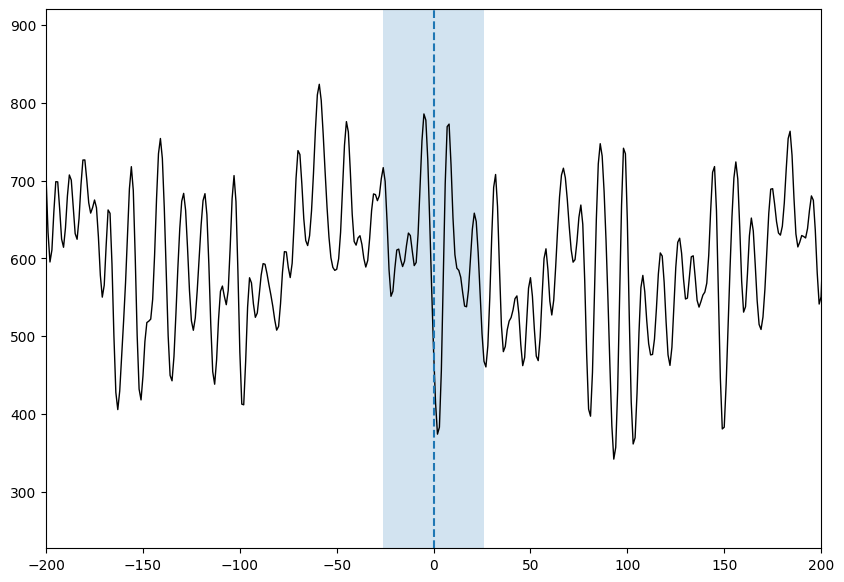

-12.0


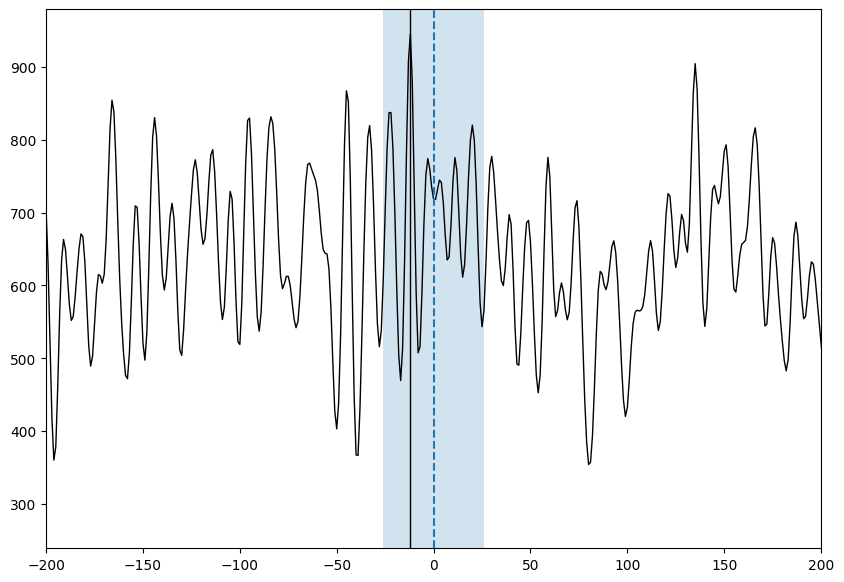

425.0


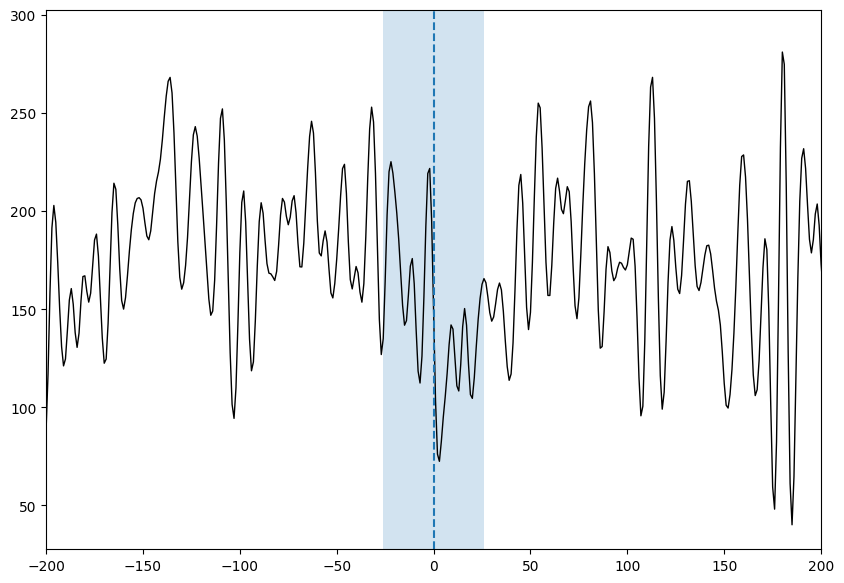

-592.0


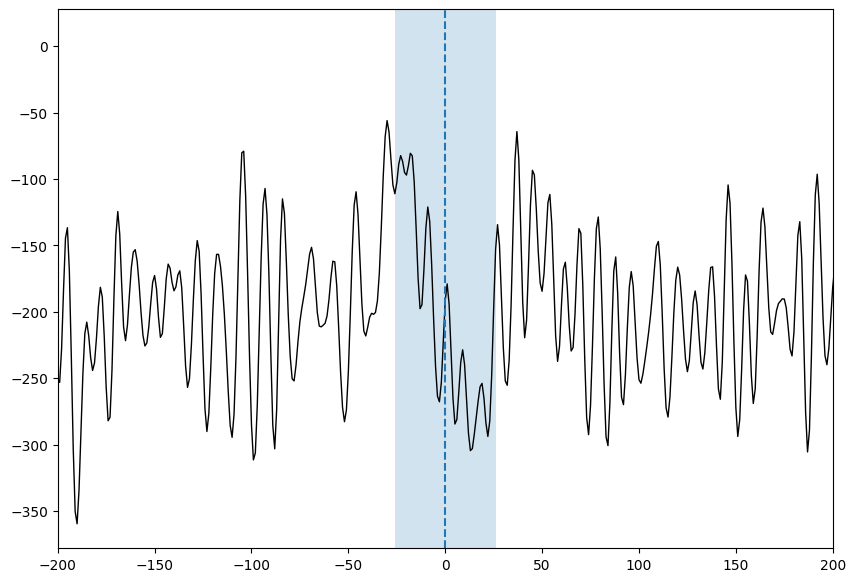

461.0


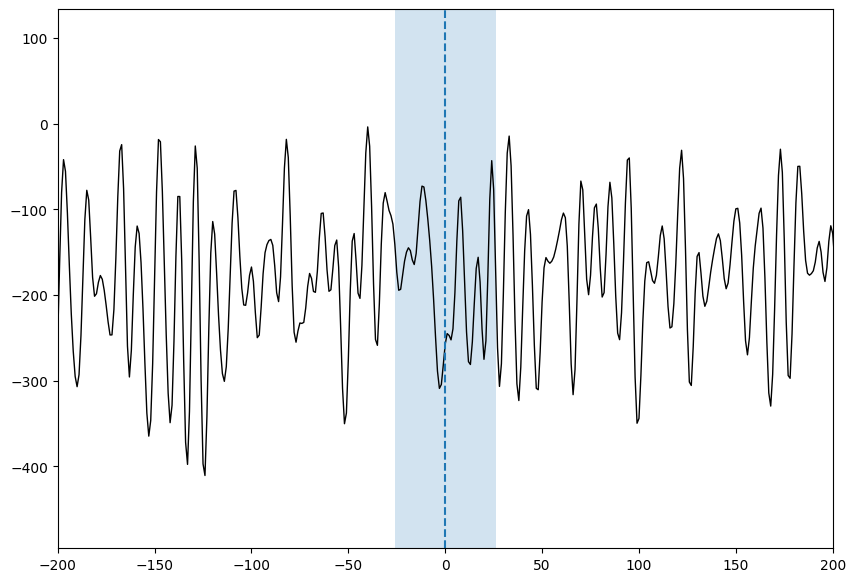

387.0


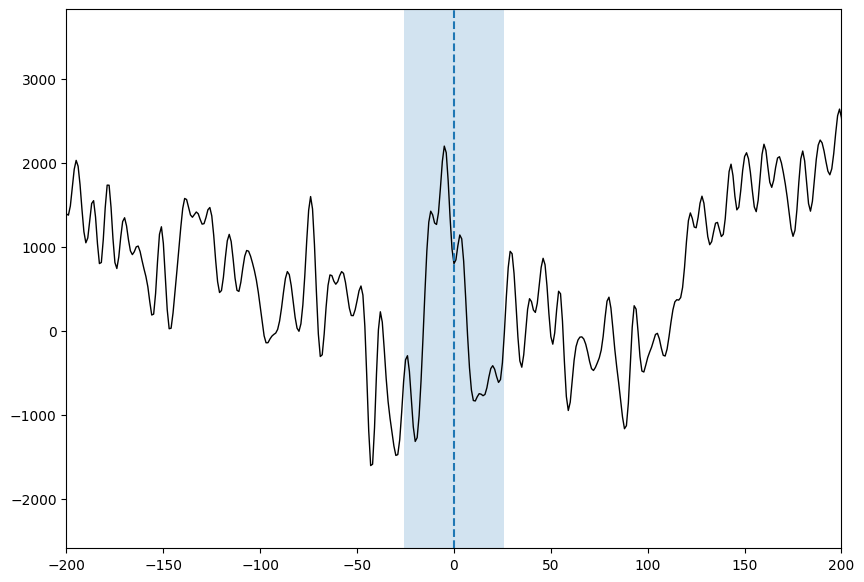

-934.0


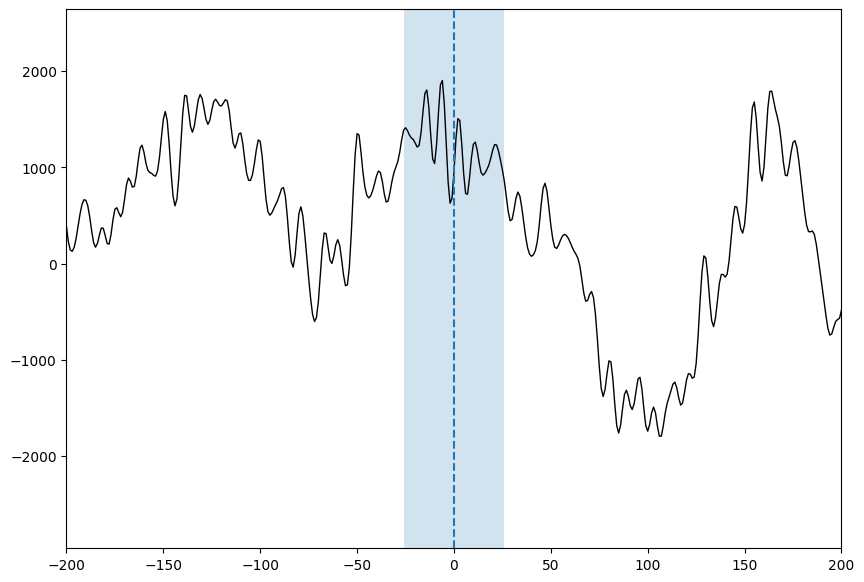

In [12]:
for i in range(d_spec.n_orders):

    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(rv, CCF[:,i,:].sum(axis=1), c='k', lw=1)

    idx = np.argmax(CCF[:,i,:].sum(axis=1))
    ax.axvline(rv[idx], c='k', ls='-', lw=1)
    print(rv[idx])

    ax.axvline(0, c='C0', ls='--')
    ax.axvspan(
        xmin=-params_global['vsini'], xmax=params_global['vsini'], 
        fc='C0', ec='none', alpha=0.2
        )

    ax.set(xlim=(-200,200))
    plt.show()